# Dogs in Vienna. Part 2: Open Data Integration Tutorial
This is a sample script showing how an open data datasets can be analysed and demonstrated using [Jupiter Notebooks](http://jupyter.org). We take the dog statistics data in Vienna as a sample use case to demonstrate common approaches to analysing open data. Similar examples can be found on [Kaggle web-site](https://www.kaggle.com/kernels).

## Open Data Story
In the previous tutorial we set out to explore the dog statistics in Vienna and discovered that there is a significant variation in the number of dogs across different districts. In this tutorial we explore additional data sets trying to explain the differences between Vienna districts that may influence the dog statistics. Here is a set of questions we have in mind:

### Research Questions
1. Why some districts have more/less dogs than others? 
2. Where should I live if I want to have a dog in Vienna?
3. Which dogs are in trend in the rich neighborhoods of Vienna?
4. What is the dog situation in my district (revisited)?

### Get the Data
Let's repeat the same step we did in the previous tutorials to load the dog stats dataset.

In [45]:
# Load libraries
import pandas as pd # CSV file processing
import numpy as np # vector and matrix manipulation

# Load the csv file from the open data portal
# dataset description: https://www.data.gv.at/katalog/dataset/stadt-wien_anzahlderhundeprobezirkderstadtwien/resource/b8d97349-c993-486d-b273-362e0524f98c
data_path = 'https://www.wien.gv.at/finanzen/ogd/hunde-wien.csv'
# Look up the row file and specify the dataset format, e.g. delimiters
data = pd.read_csv(data_path, delimiter=';', skiprows=1, thousands=',', encoding='latin-1')

# Correct individual values in the dataset
data.loc[1914, 'Anzahl'] = 1510
data.loc[5347, 'Anzahl'] = 2460

# Carefully select the string separator, including spaces!
separate_breeds = data['Dog Breed'].str.split(' / ', expand=True)
separate_breeds.columns = ["Breed_1", "Breed_2"]
data = pd.concat([data, separate_breeds], axis=1)

# Correct encoding for special characters in german alphabet
def to_utf(x):
    return x.encode('latin-1').decode('utf8') if isinstance(x, str) else x   
data = data.applymap(to_utf)

# Aggregate
data = data.groupby(['DISTRICT_CODE', 'Breed_1'])['Anzahl'].aggregate(np.sum).reset_index()
data.columns = ["DISTRICT_CODE", "Dog Breed", "Dog Count"]

# Check the top of the table to make sure the dataset is loaded correctly 
data.head()

,DISTRICT_CODE,Dog Breed,Dog Count
0,90100,Afghanischer Windhund,1
1,90100,Amerikanischer Pit-Bullterrier,1
2,90100,Amerikanischer Staffordshire-Terrier,5
3,90100,Australian Shepherd Dog,3
4,90100,Australian Terrier,1


### Get More Data

Districts of any city (town) are not homogeneous in terms of area and population. Also in Vienna some districts are bigger in terms of territory, more densely populated or wealthier than other district. These factors shall also have an effect on the dog population within the specified regions. 

Now we need to fetch this kind of data (population, area and average income per district in Vienna) in order to check its correlation with our dog stats data. https://www.data.gv.at is the biggest Austrian open data portal. Let's have a look there! 

#### Population Statistics per District
Population (Bevölkerung) seems just right for the general category, filtering on Vienna, CSV data format and community districts (Gemeindebezirke) boils down the search results to a single dataset!

Next, we just repeat the same steps we used previously to obtain the dog stats dataset:

In [46]:
# Load the csv file from the open data portal
# Dataset description: https://www.data.gv.at/katalog/dataset/stadt-wien_viebevlkerungseit1869wien/resource/c9e9d0cc-8f71-4521-b598-17d71fab2f59
data_path = 'https://www.wien.gv.at/statistik/ogd/vie_101.csv'
# Look up the row file and specify the dataset format, e.g. delimiters
data_population = pd.read_csv(data_path, delimiter=';', skiprows=1)
# Check the top of the table to make sure the dataset is loaded correctly 
data_population.head()

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,POP_TOTAL,POP_MEN,POP_WOMEN,REF_DATE
0,AT1,AT13,AT130,90100,.,68079,.,.,18691231
1,AT1,AT13,AT130,90200,.,68442,.,.,18691231
2,AT1,AT13,AT130,90300,.,88678,.,.,18691231
3,AT1,AT13,AT130,90400,.,55682,.,.,18691231
4,AT1,AT13,AT130,90500,.,54010,.,.,18691231


The dataset title informs us that the dataset contains data dating from 1869 year. We would prefer more fresh population statistics to be able to compare with the dog stats that we have dating from 2016 12 01. 

Unfortunately it is not clear from the dataset description which time periods it contains:
"VIE-Bevölkerung in den 23 Wiener Gemeindebezirken nach Geschlecht seit 1869
    Zuletzt aktualisiert	31. März 2016
    Erstellt	31. März 2016"

Let us examine the REF_DATE column, which seems to contain the reference date here.

In [47]:
# Check unique column values
data_population['REF_DATE'].unique()

array([18691231, 18801231, 19001231, 19101231, 19230307, 19340322,
       19390517, 19510601, 19610321, 19710512, 19810512, 19910515,
       20010515, 20020101, 20030101, 20040101, 20050101, 20060101,
       20070101, 20080101, 20090101, 20100101, 20110101, 20120101,
       20130101, 20140101, 20150101])

The last measurement is from 2015 (same as on Wikipedia: https://de.wikipedia.org/wiki/Wiener_Gemeindebezirke#cite_note-11). Let's take it.

In [48]:
# Slice dataset: filter specific rows and columns
population_2015 = data_population[(data_population['REF_DATE'] == 20150101)][['DISTRICT_CODE', 'POP_TOTAL']]
# Sort column
population_2015.sort_values(ascending=False, by='POP_TOTAL').head()

,DISTRICT_CODE,POP_TOTAL
630,91000,189713
642,92200,172978
641,92100,151844
622,90200,101702
636,91600,100738


## Analyse the Data
### 1. Why some districts have more/less dogs than others?
Very good we have the population count per district. Let's compare it with the dog counts. For this we need to aggregate the dog counts by district and join on the common column, which is the DISTRICT_CODE.

In [50]:
# Aggregate counts
district_dogs = data.groupby('DISTRICT_CODE')['Dog Count'].aggregate(np.sum)
# Join Data Frame and Series objects on the key column
dog_vs_people = population_2015.join(district_dogs, on='DISTRICT_CODE')
dog_vs_people.sort_values(ascending=False, by='POP_TOTAL').head()

,DISTRICT_CODE,POP_TOTAL,Dog Count
630,91000,189713,5333
642,92200,172978,8504
641,92100,151844,7143
622,90200,101702,2545
636,91600,100738,2077


In [51]:
dog_vs_people[['POP_TOTAL', 'Dog Count']].corr()

,POP_TOTAL,Dog Count
POP_TOTAL,1.000000,0.903501
Dog Count,0.903501,1.000000


As expected, dog population is positively correlated with human population (dogs usually live together with people in Vienna).

Therefore, we need to consider the district population when comparing the number of dogs across districts.

### 2. Where should I live if I want to have a dog in Vienna?

In [52]:
dog_vs_people['Dogs_per_person'] = dog_vs_people['Dog Count'] / dog_vs_people['POP_TOTAL']
# Sort by column
dog_vs_people.sort_values(ascending=True, by='Dogs_per_person').round(3).head()

,DISTRICT_CODE,POP_TOTAL,Dog Count,Dogs_per_person
635,91500,76320,1352,0.018
625,90500,54246,982,0.018
628,90800,24518,459,0.019
627,90700,31291,619,0.020
624,90400,31691,632,0.020


5th and 15th districts have the smalles propotion of dogs with respect to the number of inhabitants (18 dogs per 1000 people). We do not yet know why but it is not likely that dog-haters would agree to live closer to each other. There must be some other factors, such as necessary conditions required to have a dog, e.g. dog playgrounds, that influence the decision to have or not to have a dog.

In [53]:
# Sort by column
dog_vs_people.sort_values(ascending=False, by='Dogs_per_person').round(3).head()

,DISTRICT_CODE,POP_TOTAL,Dog Count,Dogs_per_person
642,92200,172978,8504,0.049
641,92100,151844,7143,0.047
643,92300,96775,4136,0.043
639,91900,69999,2745,0.039
633,91300,52115,1990,0.038


[<matplotlib.text.Text at 0x11428c978>, <matplotlib.text.Text at 0x1142692b0>]

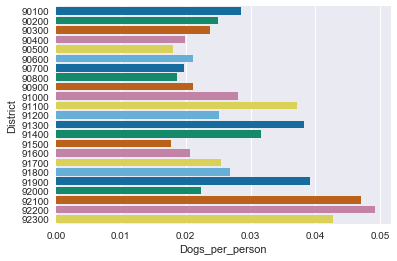

In [57]:
# Load library for visualisation
import seaborn as sns
# Command to show plots in notebook
%matplotlib inline
ax = sns.barplot(palette='colorblind', data=dog_vs_people, y=dog_vs_people.DISTRICT_CODE, x=dog_vs_people.Dogs_per_person, orient='h')
ax.set(ylabel='District', xlabel='Dogs_per_person')

22nd and 21st districts have the biggest dog populations relative to the number of inhabitants in the district: 49 and 47 dogs per 1000 people respectively. Meaning that if you live in one of this districts you are more likely to have a dog. 

Do these districts provide more favorable conditions for the dog owners? Or is it the kind of people that prefer to live in these areas also like to have dogs?

Let us explore the average income per district and whether it has an influence on the dog stats.

### Get More Data
#### Income Statistics per District
We integrate another dataset for our dog statistics analysis, which luckily follows the same logic (data format) as the previous two datasets, since it is from the same publisher (wien.gv.at). 

This dataset was relatively easy to find when searching with the keyword 'income' (einkommen) on https://www.data.gv.at portal.

In [58]:
# Load the csv file from the open data portal
# Dataset description: https://www.data.gv.at/katalog/dataset/stadt-wien_viewirtschaftwienergemeindebezirke1/resource/c1ad52a3-ca5c-44fc-a945-b6459f73ed98
data_path = 'https://www.wien.gv.at/statistik/ogd/vie_502.csv'
# The data format seems to be consistent for all the datasets from this publisher 
data_income = pd.read_csv(data_path, delimiter=';', skiprows=1)
# Check the top of the table to make sure the dataset is loaded correctly 
data_income.head()

,NUTS1,NUTS2,NUTS3,DISTRICT_CODE,SUB_DISTRICT_CODE,INCOME_TOTAL,INCOME_MEN,INCOME_WOMEN,AVERAGE_INCOME_TOTAL,AVERAGE_INCOME_MEN,AVERAGE_INCOME_WOMEN,AVERAGE_INCOME_FULLTIME_TOTAL,AVERAGE_INCOME_FULLTIME_MEN,AVERAGE_INCOME_FULLTIME_WOMEN,REF_DATE
0,AT1,AT13,AT130,90100,.,292.103.000,194.301.000,97.802.000,25.463,31.961,18.536,34.506,42.806,24.963,20021231
1,AT1,AT13,AT130,90200,.,919.962.000,559.682.000,360.280.000,16.439,18.301,14.282,22.015,24.312,19.067,20021231
2,AT1,AT13,AT130,90300,.,1.011.882.000,608.994.000,402.888.000,18.701,21.444,15.804,24.617,27.968,20.739,20021231
3,AT1,AT13,AT130,90400,.,402.479.000,243.807.000,158.672.000,20.325,23.641,16.876,27.348,31.586,22.539,20021231
4,AT1,AT13,AT130,90500,.,554.361.000,327.128.000,227.233.000,16.258,17.937,14.395,22.059,24.198,19.454,20021231


In [59]:
# Check unique column values
data_income['REF_DATE'].unique()

array([20021231, 20031231, 20041231, 20051231, 20061231, 20071231,
       20081231, 20091231, 20101231, 20111231, 20121231, 20131231, 20141231])

The last measurement is from 2014. Let's take it.

In [60]:
# Slice dataset: filter specific rows and columns
income_2014 = data_income[(data_income['REF_DATE'] == 20141231)][['DISTRICT_CODE', 'AVERAGE_INCOME_TOTAL']]
# Sort column
income_2014.sort_values(ascending=False, by='AVERAGE_INCOME_TOTAL').head()

,DISTRICT_CODE,AVERAGE_INCOME_TOTAL
276,90100,32.493
288,91300,27.604
294,91900,25.803
279,90400,24.199
293,91800,24.164


All right, this is common knowledge ;)  The wealthiest are 1st and 13th districts of Vienna. 

In [61]:
income_2014.sort_values(ascending=True, by='AVERAGE_INCOME_TOTAL').head()

,DISTRICT_CODE,AVERAGE_INCOME_TOTAL
290,91500,16.799
295,92000,17.861
285,91000,18.340
291,91600,18.733
280,90500,18.952


The poorest are the 15th and 20th districts. 

[<matplotlib.text.Text at 0x114464048>, <matplotlib.text.Text at 0x1144c10f0>]

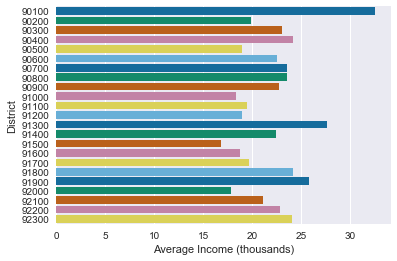

In [62]:
# Plot pandas data frame
ax = sns.barplot(data=income_2014,palette='colorblind', y='DISTRICT_CODE', x='AVERAGE_INCOME_TOTAL', orient='h')
ax.set(ylabel='District', xlabel='Average Income (thousands)')

Now let's join all our datasets with district stats.

In [63]:
# Merge data frames on the key column
dog_vs_people_vs_income = dog_vs_people.merge(income_2014, on='DISTRICT_CODE')
dog_vs_people_vs_income.sort_values(ascending=False, by='AVERAGE_INCOME_TOTAL').head()

,DISTRICT_CODE,POP_TOTAL,Dog Count,Dogs_per_person,AVERAGE_INCOME_TOTAL
0,90100,16339,465,0.028460,32.493
12,91300,52115,1990,0.038185,27.604
18,91900,69999,2745,0.039215,25.803
3,90400,31691,632,0.019943,24.199
17,91800,49178,1316,0.026760,24.164


In [64]:
dog_vs_people_vs_income.corr()

,DISTRICT_CODE,POP_TOTAL,Dog Count,Dogs_per_person,AVERAGE_INCOME_TOTAL
DISTRICT_CODE,1.000000,0.453962,0.563003,0.592619,-0.213271
POP_TOTAL,0.453962,1.000000,0.903501,0.554129,-0.455340
Dog Count,0.563003,0.903501,1.000000,0.813967,-0.178365
Dogs_per_person,0.592619,0.554129,0.813967,1.000000,0.273133
AVERAGE_INCOME_TOTAL,-0.213271,-0.455340,-0.178365,0.273133,1.000000


There is no strong correlation between the average income and the number of dogs. Everyone likes to have a dog. Maybe a different kind of dog though...

Is there a correlation between a dog breed and the income of its owners?

### 3. Which dogs are in trend in the rich neighborhoods of Vienna?
We need to go back to the breed-level district statistics to answer this question.

In [198]:
# Filter out specific rows
filtered_dogs = data.loc[data['Dog Breed']!='Unbekannt']
filtered_dogs.head()

,DISTRICT_CODE,Dog Breed,Dog Count
0,90100,Afghanischer Windhund,1
1,90100,Amerikanischer Pit-Bullterrier,1
2,90100,Amerikanischer Staffordshire-Terrier,5
3,90100,Australian Shepherd Dog,3
4,90100,Australian Terrier,1


Next, we need the relative counts instead of the absolute counts for the breeds to be able to compare across districts.

In [218]:
district_stats = filtered_dogs.merge(dog_vs_people, on='DISTRICT_CODE')
district_stats['Breed_Percent'] = ((district_stats['Dog Count_x'] / district_stats['Dog Count_y']) * 100).astype(int)
# Drop 0 values
district_stats = district_stats[(district_stats['Breed_Percent']>0)]
district_stats.sort_values(ascending=False, by='Breed_Percent').head()

,DISTRICT_CODE,Dog Breed,Dog Count_x,POP_TOTAL,Dog Count_y,Dogs_per_person,Breed_Percent
2610,91900,Labrador Retriever,193,69999,2745,0.039215,7
1672,91300,Labrador Retriever,148,52115,1990,0.038185,7
2432,91800,Labrador Retriever,94,49178,1316,0.026760,7
51,90100,Labrador Retriever,35,16339,465,0.028460,7
1295,91100,Chihuahua kurzhaariger Schlag,271,95198,3539,0.037175,7


In [219]:
# Create a “pivot” table based on column values unfolding the original table stats
unfolded_breeds = district_stats.pivot_table(index='DISTRICT_CODE', columns='Dog Breed', values='Breed_Percent').fillna(0).astype(int)
unfolded_breeds.reset_index(level=0, inplace=True)
unfolded_breeds.head()

Dog Breed,DISTRICT_CODE,Amerikanischer Pit-Bullterrier,Amerikanischer Staffordshire-Terrier,Australian Shepherd Dog,Beagle,Border-Collie,Boxer,Cavalier King Charles Spaniel,Chihuahua kurzhaariger Schlag,Chihuahua langhaariger Schlag,...,Shih Tzu,Siberian Husky,Spitz,Toy-Pudel,Weimaraner,West Highland White Terrier,Yorkshire Terrier,Zwergpinscher,Zwergschnauzer,Zwergspitz
0,90100,0,1,0,1,1,1,0,2,0,...,1,0,0,1,1,1,1,0,0,0
1,90200,0,2,0,1,1,0,0,5,1,...,1,0,0,0,0,0,3,1,0,1
2,90300,0,2,0,0,1,0,0,5,0,...,0,1,0,0,0,1,1,1,0,0
3,90400,0,1,0,2,0,0,0,2,1,...,0,0,0,0,0,1,1,0,0,0
4,90500,1,3,0,1,0,0,0,4,1,...,0,0,0,0,0,0,2,1,0,0


In [221]:
breeds_vs_income = unfolded_breeds.merge(income_2014, on='DISTRICT_CODE')
c = breeds_vs_income.corr()
s = c.unstack()
s.sort_values(ascending=False)['AVERAGE_INCOME_TOTAL']

AVERAGE_INCOME_TOTAL                    1.000000
Labrador Retriever                      0.741681
Toy-Pudel                               0.633378
Schnauzer                               0.633378
Parson-Russell-Terrier                  0.633378
Weimaraner                              0.633378
Flat Coated Retriever                   0.633378
Magyar Vizsla                           0.549162
West Highland White Terrier             0.434112
Pudel                                   0.418268
Rauhhaardackel (Zwergdackel)            0.418139
Border-Collie                           0.388188
Boxer                                   0.349132
Englischer Cockerspaniel                0.223980
Beagle                                  0.223901
Golden Retriever                        0.211484
Dackel                                  0.178157
Zwergschnauzer                          0.089984
Drahthaar-Foxterrier                    0.084796
Spitz                                   0.084796
Cavalier King Charle

That is it! Labradors and Toy-Pudels are positively correlated with higher incomes. Staff, Pit-Bull and Chihuahuas with lower.

### 4. Open Data for Local Communities
Let us analyse district statistics on the example of the 2nd district (Leopoldstadt). 

You can replace the district code in the variable below to see the stats for your own district.

In [138]:
district = 90200
# Get the slice of the joint dataset according to the search query
dog_vs_people_vs_income.head()
district_dogs = dog_vs_people_vs_income.loc[dog_vs_people_vs_income.DISTRICT_CODE==district]
district_dogs

,DISTRICT_CODE,POP_TOTAL,Dog Count,Dogs_per_person,AVERAGE_INCOME_TOTAL
1,90200,101702,2545,0.025024,19.887


Let us compare this stats with the averages across all Vienna districts.

In [139]:
dog_vs_people_vs_income.describe()

,DISTRICT_CODE,POP_TOTAL,Dog Count,Dogs_per_person,AVERAGE_INCOME_TOTAL
count,23.000000,23.000000,23.000000,23.000000,23.000000
mean,91200.000000,78145.086957,2431.695652,0.028148,22.115696
std,678.232998,45913.577588,2111.114019,0.009538,3.571603
min,90100.000000,16339.000000,459.000000,0.017715,16.799000
25%,90650.000000,45030.000000,922.000000,0.020841,19.236000
50%,91200.000000,76320.000000,1990.000000,0.025111,22.505000
75%,91750.000000,95986.500000,2787.000000,0.034427,23.825500
max,92300.000000,189713.000000,8504.000000,0.049162,32.493000


2nd district is among the largest districts in Vienna in terms of population (in the 4th quantile: 95,986 < 101,702 < 189,713). 

It is below average with respect to the official income statistics (in the 2nd quantile: 19,236 < 19,887 < 22,505).

There is a single dog per 40 inhabitants (25 dogs/1,000 people) which is the average in Vienna.

## Lessons Learned

### Dogs in Vienna

Based on the data available we were able to provide comprehensive answers to the set of research questions proposed in the introduction.

1. The dogs are distributed propotional to the number of people across the districts.
2. However, some districts seem to have fewer dogs than expected (5th and 15th) and some more (21th and 22th), which points to other factors that may influence the decision to acquire a dog pet, such as availability of dog playgrounds in the area or ability to sustain the dog, i.e. income of the owner.
3. Labradors, Toy-Pudels, Schnauzer, Parson-Russell Terriers, Weimaraner, Flat Coated Retrievers, Magyar Vizsla and West Highland White Terriers are the favorites of the upscale districts in Vienna. This may correlate with the dog prices as well.
4. Leopoldstadt is a big relatively poor district with an adequate proportion of dogs. Statistics on population and average income provides us additional insights into the situation in our neighborhouds, which may be useful for other types of analysis as well.


### Open Data Quality
    1. Descriptions do not provide enough information on what kind of data the dataset contains, e.g. the date span in our example.
    2. Formatting is consistent for the same publisher, which is the good news. Especially if it is a big publisher with many datasets, such as governmental agency.  
    
### Process
    1. Find datasets, e.g. CSV files from open data portals
    2. Refine: identify column separator, thousands separator, rows to skip, string encoding, etc.
    3. Aggregate: group by different attributes, e.g. district or type, and sum up the counts.
    4. Join datasets on the common key, e.g. district code identifier.
    5. Check correlation between the columns.

## Inspired by
1. [Detail Analysis of various Hospital factors](https://www.kaggle.com/nirajvermafcb/d/cms/hospital-general-information/detail-analysis-of-various-hospital-factors)
2. Wheelan, Charles J. Naked Statistics. 2013

## More Vienna Dog Data
1. [Hundezonen in Wien](https://www.wien.gv.at/umwelt/parks/hundezonen.html)
2. [Hunde, Hundezonen und Hundekotsackerlspender nach Bezirken 2015](https://www.wien.gv.at/statistik/lebensraum/tabellen/hundezonen-bez.html)